<a href="https://colab.research.google.com/github/BeWildering/comp-semantics/blob/main/CompositionalSemantics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [5]:
import os
import urllib.request
import numpy as np
import pandas as pd
import math
import re

# Get the interactive Tools for Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.parsing.preprocessing import remove_stopwords

# !python -m spacy download en_core_web_md
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

#Show all columns of dataframe
pd.options.display.max_columns = None
pd.options.display.max_rows = None

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Load word embeddings

In [6]:
# from gensim.scripts.glove2word2vec import glove2word2vec

if not os.path.exists('/content/glove.6B.zip'):
  urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip', 'glove.6B.zip')
if not os.path.exists('/content/glove.6B.100d.txt'):
  !unzip /content/glove.6B #unzip compressed file

glove_file = datapath('/content/glove.6B.300d.txt')

tmp_file = "/content/glove_tmp"
glove2word2vec(glove_file, tmp_file)
print(tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
/content/glove_tmp


Gensim word similarity functions

[('immanuel', 0.6443918943405151), ('hegel', 0.616576075553894), ('schopenhauer', 0.5629166960716248), ('nietzsche', 0.5363221168518066), ('spinoza', 0.5046462416648865), ('aristotle', 0.5012214183807373), ('plato', 0.5011799335479736), ('kantian', 0.500676155090332), ('metaphysics', 0.493084192276001), ('philosophers', 0.48889487981796265)]
[('keyrates', 0.5349509119987488), ('rw97', 0.49975526332855225), ('23aou94', 0.4935912489891052), ('ryryryryryry', 0.4564247131347656), ('fazilah', 0.4550938606262207), ('27aou94', 0.45430704951286316), ('zety', 0.442155659198761), ('http://www.opel.com', 0.43997466564178467), ('+9.00', 0.43731439113616943), ('.70952', 0.43573370575904846)]
0.5622518
brought: 0.4219
[('elk', 0.6696363687515259), ('boar', 0.5721302032470703), ('moose', 0.537537693977356), ('shmahn', 0.5307357311248779), ('antelope', 0.5266754627227783), ('white-tailed', 0.5219253301620483), ('squirrels', 0.5185477137565613), ('foxes', 0.5006103515625), ('rabbits', 0.496606141328811

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


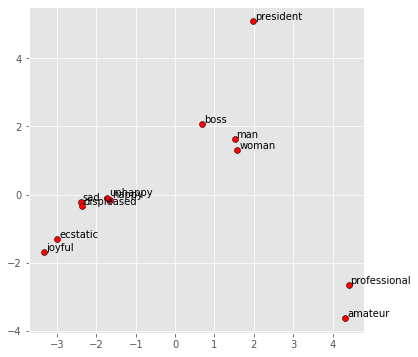

In [7]:
print(model.most_similar('kant'))
print(model.most_similar(negative='opal'))
print(model.similarity("happy", "unhappy"))

result = model.most_similar(positive=['colorful','sky'], negative=['colorless','uncolored','colourless'])
print("{}: {:.4f}".format(*result[0]))

def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result
print(analogy('male', 'deer', 'female'))

print(model.doesnt_match("breakfast cereal dinner lunch".split()))

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.index2word), sample)
        else:
            words = [ word for word in model.vocab ]
    word_vectors = np.array([model[w] for w in words])
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

display_pca_scatterplot(model, ["woman", "man", "boss", "professional", "amateur", "president",
                                "happy", "unhappy", "sad", "ecstatic", "displeased", "joyful"])

Define functions for semantic composition (old)

In [8]:
'''
def get_features(text):
  """Extract linguistic features via Spacy. Also calculate dependency weights"""
  doc = nlp(text)
  sent = pd.DataFrame(columns=['token','dep','head','head_pos','children'])
  for token in doc:
    sent = sent.append({'token': token.text, 'pos': token.pos_, 'dep': token.dep_, 'head': token.head.text, 'head_pos': token.head.pos_,
              'children': [child for child in token.children]}, ignore_index=True)
  return sent

# This one is not very good. Use child count instead.
def add_dep_wts_head(features):
  '''Add dependency weights based on number of tokens with given word listed as head.'''
  counts = features['head'].value_counts()
  dep_weight = []
  for token in features['token']:
    dep_weight.append(counts.get(token, 0) + 1)
  features.insert(4, "dep_wt", dep_weight)
  return features

def add_dep_wts(features):
  '''Add dependency weights based on number of child nodes.'''
  features['dep_wt'] = features.apply(lambda row: len(row['children']) + 1, axis=1)
  return features

def add_dep_wts_log(features):
  '''Add dependency weights based on number of child nodes.'''
  features['dep_wt_log'] = features.apply(lambda row: math.log(row['dep_wt'], 10) + 1, axis=1)
  return features

def get_ants(token_df):
  pos_keys = {'VERB': 'v',
              'ADV': 'r',
              'ADJ': 'a',
              'NOUN': 'n',
              }
  ants = []
  for w,p in zip(token_df.token, token_df.pos):
    if p in pos_keys.keys():                      # only consider verb, adv, adj, and noun
      for s in wn.synsets(w, pos=pos_keys[p]):
        for l in s.lemmas():
          if l.antonyms():
            ants.append(l.antonyms()[0].name()) # get first antonym for any sense
            break
          else:
            ants.append(None)
          break
        else:
          continue
        break
    else:
      ants.append(None)
  token_df.insert(len(token_df.columns), "ant", ants)
  return token_df'''

SyntaxError: ignored

Scratch work

In [ ]:
def get_features(text):
  """Extract linguistic features via Spacy. Also calculate dependency weights"""
  doc = nlp(text)
  features = pd.DataFrame(columns=['token', 'pos','head','children'])
  for token in doc:
    features = features.append({'token': token.text,
                                'pos': token.pos_,
                                # 'dep': token.dep_,
                                'head': token.head.text,
                                # 'head_pos': token.head.pos_,
                                'children': [child for child in token.children]},
                               ignore_index=True)
  print(features)
  features['dep_wt'] = features.apply(lambda row: len(row['children']) + 1, axis=1)
  features['dep_wt_log'] = features.apply(lambda row: math.log(row['dep_wt'], 10) + 1, axis=1)
  print(features)
  return features
  # features = get_ants(features)
  # return features

def get_ants(token_df):
  '''Generate antonyms'''
  pos_keys = {'VERB': 'v', 'ADV': 'r', 'ADJ': 'a', 'NOUN': 'n'}
  ants = []
  for w,p in zip(token_df.token, token_df.pos):
    if p in pos_keys.keys():                      # only consider verb, adv, adj, and noun
      print(w)
      for s in wn.synsets(w, pos=pos_keys[p]):
        print(s)
        for l in s.lemmas():
          print(l)
          if l.antonyms():
            print(l.antonyms())
            ants.append(l.antonyms()[0].name())   # get first antonym for any sense
            print('added')
            break
          else:
            ants.append(None)
            print('added')
          break
        else:
          continue
        break
      else:
        ants.append(None)
    else:
      print(w)
      ants.append(None)
      print('added')
  print(len(ants))
  token_df.insert(len(token_df.columns), "ant", ants)
  return token_df

features = get_features('an area of ground where plants such as flowers or vegetables are grown')
get_ants(features)


Component Functions

In [9]:
def product(x):
  '''Calculate the product of a series'''
  prod = 1
  for w in x:
    prod = prod * w
  return prod

def get_ants(token_df):
  '''Generate antonyms'''
  pos_keys = {'VERB': 'v', 'ADV': 'r', 'ADJ': 'a', 'NOUN': 'n'}
  ants = []
  for w,p in zip(token_df.token, token_df.pos):
    if p in pos_keys.keys():                      # only consider verb, adv, adj, and noun
      for s in wn.synsets(w, pos=pos_keys[p]):
        for l in s.lemmas():
          if l.antonyms():
            ants.append(l.antonyms()[0].name())   # get first antonym for any sense
            break
          else:
            ants.append(None)
          break
        else:
          continue
        break
      else:
        ants.append(None)
    else:
      ants.append(None)
  token_df.insert(len(token_df.columns), "ant", ants)
  return token_df

def get_features(text):
  """Extract linguistic features via Spacy. Also calculate dependency weights"""
  doc = nlp(text)
  features = pd.DataFrame(columns=['token', 'pos','head','children'])
  for token in doc:
    features = features.append({'token': token.text,
                                'pos': token.pos_,
                                # 'dep': token.dep_,
                                'head': token.head.text,
                                # 'head_pos': token.head.pos_,
                                'children': [child for child in token.children]},
                               ignore_index=True)
  features['dep_wt'] = features.apply(lambda row: len(row['children']) + 1, axis=1)
  features['dep_wt_log'] = features.apply(lambda row: math.log(row['dep_wt'], 10) + 1, axis=1)
  features = get_ants(features)
  return features

innerA = lambda x: [w for w,wt in x]
innerB = lambda x: [sum(model[w]*wt for w,wt in x)]
innerC = lambda x: [product(model[w]*wt for w,wt in x)]

outerA = lambda x,y: model.most_similar(positive=x, negative=y, topn=20)
outerB = lambda x,y: model.most_similar_cosmul(positive=x, negative=y, topn=20)

combA = (innerA, outerA)  # 3CosAdd
combB = (innerA, outerB)  # 3CosMul
combC = (innerB, outerA)  # Add
combD = (innerC, outerA)  # Mul

wtA = lambda x: [1]*len(x)
wtB = lambda x: x.dep_wt
wtC = lambda x: x.dep_wt_log

stopA = lambda x: x   # Return dataframe with stopwords
def stopB(tokens_df):
  '''Return dataframe without stopwords'''
  stopless = remove_stopwords(' '.join(tokens_df['token'])).split()
  return tokens_df[tokens_df['token'].isin(stopless)]

negA = lambda x: [] # Don't include antonyms
negB = lambda x: x  # Include antonyms

combs = [combA,combB,combC,combD]
wts = [wtA,wtB,wtC]
stops = [stopA,stopB] 
negs = [negA,negB]

def compose(tokens_df, comb_type, wt_type, stop_type, neg_type):
  stop_df = stop_type(tokens_df)                                          # focus on non-stopwords
  p = comb_type[0](zip(stop_df.token, wt_type(stop_df)))                  # combine positives
  ants_df = stop_df[stop_df['ant'].values != None]                        # focus on antonyms
  if len(ants_df) == 0:
    n = []
  else:
    n = comb_type[0](zip(ants_df.ant, wt_type(ants_df)))                    # combine negatives
  most_sim = comb_type[1](p, neg_type(n))
  return [w[0] for w in most_sim if w[0] not in list(stop_df.token)][:10]    # first 10 original words to be generated


Data collection

In [10]:
#Initiate storage dict
total = {}
scores = {}
for i in range(24):
  scores[i] = []

In [60]:
word = 'student'
description = "a person who attends a school, college, or university"

total[word] = [description]

new = []

raw_string = total[word][0]
word_string = re.sub(r'[^\w\s]', '', raw_string)

tokens = get_features(word_string)
print(tokens)
print()
print(stopB(tokens))
print()

i,j,k,l,m = 0,0,0,0,0
for comb in combs:
  i+=1
  j,k,l = 0,0,0
  if comb == combC:
    for wt in wts:
      j+=1
      k,l = 0,0
      for stop in stops:
        k+=1
        l = 0
        for neg in negs:
          l+=1
          m+=1
          result = compose(tokens, comb, wt, stop, neg)
          new.append(result)
          print(m, '--', 'comb:', i,'wt:', j,'stop:', k,'neg:', l, result)
  else:
    wt = wtA
    for stop in stops:
      k+=1
      l = 0
      for neg in negs:
        l+=1
        m+=1
        result = compose(tokens, comb, wt, stop, neg)
        new.append(result)
        print(m, '--', 'comb:', i,'wt:', j,'stop:', k,'neg:', l, result)

total[word].append(np.array(new))
total[word][1]

locations = np.where(total[word][1] == word)

scores_new = {}
for i in range(24):
  scores_new[i] = 0

for i in range(len(locations[0])):
  scores_new[locations[0][i]] = 10 - locations[1][i]

for key in scores_new.keys():
  scores[key].append(scores_new[key])

print(scores)
print(scores_new)

# compose(tokens, combC, wtA, stopB, negA)

        token    pos     head                     children  dep_wt  \
0           a    DET   person                           []       1   
1      person   NOUN   person                 [a, attends]       3   
2         who   PRON  attends                           []       1   
3     attends   VERB   person               [who, college]       3   
4           a    DET  college                           []       1   
5      school   NOUN  college                           []       1   
6     college   NOUN  attends  [a, school, or, university]       5   
7          or  CCONJ  college                           []       1   
8  university   NOUN  college                           []       1   

   dep_wt_log   ant  
0    1.000000  None  
1    1.477121  None  
2    1.000000  None  
3    1.477121  miss  
4    1.000000  None  
5    1.000000  None  
6    1.698970  None  
7    1.000000  None  
8    1.000000  None  

        token   pos     head                     children  dep_wt  dep_wt_log 

In [61]:

# locations = np.where(total[word][1] == word)

# scores_new = {}
# for i in range(24):
#   scores_new[i] = 0

# for i in range(len(locations[0])):
#   scores_new[locations[0][i]] = locations[1][i]

# for key in scores_new.keys():
#   scores[key].append(scores_new[key])

# print(scores)
# print(scores_new)
# del total['stop']

print(len(total.keys()))
print(total.keys())
print([part[0] for part in list(total.values())])
scores


25
dict_keys(['attack', 'breakfast', 'chocolate', 'different', 'expensive', 'foreign', 'grandfather', 'healthy', 'important', 'join', 'knife', 'length', 'medicine', 'newspaper', 'obey', 'pain', 'question', 'radio', 'salt', 'tool', 'understand', 'voice', 'why', 'young', 'student'])
['to act violently against', 'the first meal of the day', 'a food that is made from cacao beans and that is eaten as candy or used as a flavoring ingredient in other sweet foods', 'partly or totally unlike', 'costing a lot of money', 'coming from or belonging to a different place or country', 'the father of your father or mother', 'having good health', 'deserving or requiring serious attention', 'to put or bring (two or more things) together', 'a usually sharp blade attached to a handle that is used for cutting or as a weapon', 'a measurement of how long something is', 'a substance that is used in treating disease or relieving pain and that is usually in the form of a pill or a liquid', 'a set of large sheets

{0: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8],
 1: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  9],
 2: [0,
  0,
  6,
  0,
  0,
  0,
  6,
  0,
  0,
  0,
  5,
  9,
  0,
  0,
  0,
  9,
  0,
  0,
  0,
  0,
  8,
  10,
  8,
  0,
  9],
 3: [0,
  0,
  5,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  8,
  8,
  0,
  9],
 4: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  10],
 5: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  10],
 6: [0,
  1,
  6,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  4,
  10,
  0,
  0,
  0,
  9,
  0,
  0,
  0,
  0,
  8,
  10,
  5,
  0,
  10],
 7: [0,
  1,
  5,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0

In [63]:
scores_df = pd.DataFrame()
for item in scores.keys():
  scores_df = scores_df.append(pd.Series(scores[item]), ignore_index=True)
scores_df.columns = total.keys()
# print(scores_df)

# tots = scores_df.sum(axis=1)
# print(tots)

scores_df.insert(len(scores_df.keys()), 'total', scores_df.sum(axis=1))

print(scores_df)


# scores_df.to_csv('/content/drive/MyDrive/Colab Notebooks/compsem_scores_50.csv')

    attack  breakfast  chocolate  different  expensive  foreign  grandfather  \
0      0.0        0.0        0.0        0.0        0.0      0.0          0.0   
1      0.0        0.0        0.0        0.0        0.0      0.0          0.0   
2      0.0        0.0        6.0        0.0        0.0      0.0          6.0   
3      0.0        0.0        5.0        0.0        0.0      0.0          8.0   
4      0.0        0.0        0.0        0.0        0.0      0.0          0.0   
5      0.0        0.0        0.0        0.0        0.0      0.0          0.0   
6      0.0        1.0        6.0        0.0        0.0      0.0          7.0   
7      0.0        1.0        5.0        0.0        0.0      0.0          8.0   
8      0.0        0.0        0.0        0.0        0.0      0.0          0.0   
9      0.0        0.0        0.0        0.0        0.0      0.0          0.0   
10     0.0        6.0        6.0        0.0        0.0      0.0          7.0   
11     0.0        6.0        4.0        

In [64]:
scores_df.to_csv('/content/drive/MyDrive/Colab Notebooks/compsem_scores_50.csv')

Test models/functions (old)

In [67]:
'''word_string = "a very small animal that has a pointed nose and a long, thin tail"

tokens = get_features(word_string)
tokens = add_dep_wts(tokens)
tokens = add_dep_wts_log(tokens)
tokens = get_ants(tokens)
words = tokens['token']


# get antonyms - check with mouse def
# ants = []
# for w in words:
#   if wn.synsets(w):
#     s = wn.synsets(w)[0]
#     if s.lemmas():
#       l = s.lemmas()[0]
#       if l.antonyms():
#         ants.append(l.antonyms()[0].name())
# print('antonyms:', ants)

basic = lambda x: [w for w in x]
ave = lambda x: [sum(model[w] for w in x)/len(x)]
added = lambda x: [sum(model[w] for w in x)]

def wt_add(tokens_df):
  words = tokens_df['token']
  redist = []
  for w in words: #multiply vectors by dependency weights
    redist.append(model[w] * int(list(tokens_df['dep_wt_log'][tokens_df['token'] == w])[0]))
  return [sum(redist)]

def wt_add_unstop(tokens_df):
  words = remove_stopwords(' '.join(tokens_df['token'])).split()
  # filtered_df = tokens_df[tokens_df.token.isin(words)]
  redist = []
  for w in words: #multiply vectors by dependency weights
    redist.append(model[w] * int(list(tokens_df['dep_wt_log'][tokens_df['token'] == w])[0]))
  return [sum(redist)]

def mult(x):
  prod = 1
  for w in x:
    prod = prod * model[w]
  return [prod]

df = pd.DataFrame()
df.insert(len(df.columns), "CosAdd", [w[0] for w in model.most_similar(positive=basic(words))])
df.insert(len(df.columns), "CosMult", [w[0] for w in model.most_similar_cosmul(positive=basic(words))])
df.insert(len(df.columns), "Added", [w[0] for w in model.most_similar(positive=added(words))])
df.insert(len(df.columns), "Weighted", [w[0] for w in model.most_similar(positive=wt_add(tokens))])
df.insert(len(df.columns), "Weighted_No_Stops", [w[0] for w in model.most_similar(positive=wt_add_unstop(tokens))])
# df.insert(len(df.columns), "Mult", [w[0] for w in model.most_similar(positive=mult(words))])

df.insert(len(df.columns), "CosAdd_neg", [w[0] for w in model.most_similar(positive=basic(words), negative=ants)])
df.insert(len(df.columns), "CosMult_neg", [w[0] for w in model.most_similar_cosmul(positive=basic(words), negative=ants)])
df.insert(len(df.columns), "Added_neg", [w[0] for w in model.most_similar(positive=added(words), negative=ants)])
df.insert(len(df.columns), "Weighted_neg", [w[0] for w in model.most_similar(positive=wt_add(tokens), negative=ants)])
df.insert(len(df.columns), "Weighted_No_Stops_neg", [w[0] for w in model.most_similar(positive=wt_add_unstop(tokens), negative=ants)])
# df.insert(len(df.columns), "Mult", [w[0] for w in model.most_similar(positive=mult(words), negative=ants)])


# df.insert(len(df.columns), "Weighted Ave", [w[0] for w in model.most_similar(positive=[model[words[0]] + model[words[1]] + 2*model[words[2]]])])
print()
print(df)

print()
print(tokens)
'''


    CosAdd  CosMult Added Weighted Weighted_No_Stops CosAdd_neg CosMult_neg  \
0      but      but     a        a              tail        but         but   
1       so       so   but      but              long         so          so   
2     well     even  that     that             small        one         one   
3     this     well    so       so           pointed       well        even   
4     even   though  very     very              nose       this      though   
5       it       it  long     long             large      which        well   
6    which    which  this     this                 ,       even       which   
7   though     this  even     even               but     though        same   
8  because  because    it       it                so    another        this   
9  another      one  well     well            though         it     another   

  Added_neg Weighted_neg Weighted_No_Stops_neg  
0         a            a                  tail  
1       but          but       